## Configurando ambiente para conexão com base de dados: kaggle

In [1]:
!pip install kaggle --quiet

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

In [4]:
!mv kaggle.json /root/.kaggle/

### Download da base de dados

In [5]:
!kaggle datasets download -d leonardocosta1206/monet-renoir-wikiart

Dataset URL: https://www.kaggle.com/datasets/leonardocosta1206/monet-renoir-wikiart
License(s): unknown
monet-renoir-wikiart.zip: Skipping, found more recently modified local copy (use --force to force download)


## Importando e lendo os aqruivos baixados

### Extraindo as imagens do arquivo .zip

In [6]:
import zipfile
import os
import pandas as pd

os.makedirs('./data', exist_ok=True)

zip_path = './monet-renoir-wikiart.zip'
extract_folder = './data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

### Importando e pre-processando as imagens

In [7]:
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def pre_process(img):
    img = img.resize((256, 256))
    img = img.convert('L')
    img = np.array(img)
    img = img / 255.0

    return img


def load_images_from_folder(folder):
    monet_images = []
    renoir_images = []

    for subdir, dirs, files in os.walk(folder):
        for file in tqdm(files):
            if file.endswith('.jpg'):
                img_path = os.path.join(subdir, file)
                img = Image.open(img_path)
                img = pre_process(img)
                if "monet" in subdir.lower():
                    monet_images.append(img)
                elif "renoir" in subdir.lower():
                    renoir_images.append(img)

    return monet_images, renoir_images

In [8]:
monet_images, renoir_images = load_images_from_folder(extract_folder)

0it [00:00, ?it/s]
100%|██████████| 1376/1376 [00:54<00:00, 25.03it/s]


In [9]:
def plot_sample_images(images):
  fig, axs = plt.subplots(1, 5, figsize=(20, 5))

  for i, image in enumerate(images[:5]):
      axs[i].imshow(image, cmap='gray')
      axs[i].axis('off')

  plt.tight_layout()
  plt.show()

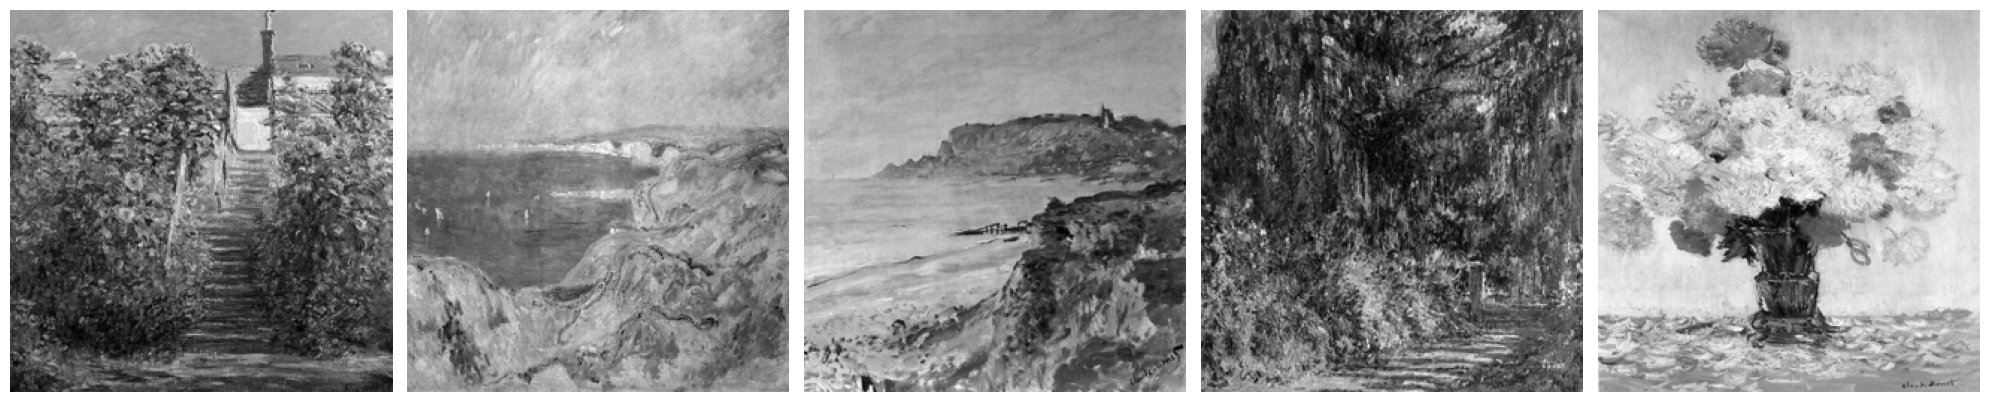

In [10]:
plot_sample_images(monet_images)

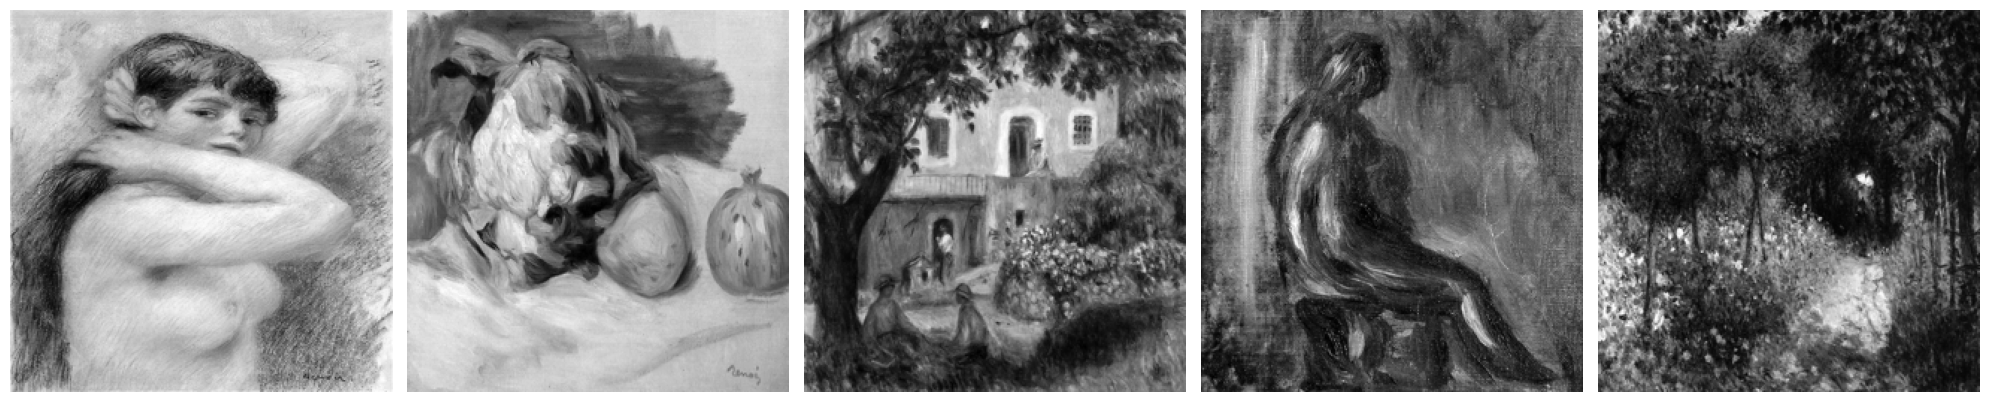

In [11]:
plot_sample_images(renoir_images)

## Preparando as imagens para serem processadas

In [12]:
def prepare_for_keras(monet_images, renoir_images):
    all_images = monet_images + renoir_images

    X_data = np.array(all_images)
    X_data = np.expand_dims(X_data, axis=-1)

    y_data = np.array([0] * len(monet_images) + [1] * len(renoir_images))

    return X_data, y_data

In [13]:
X_data, y_data = prepare_for_keras(monet_images, renoir_images)

In [14]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.1, validation_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    validation_ratio = validation_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_data, y_data, test_size=0.2, validation_size=0.2)

In [16]:
del X_data, y_data

## Transfer learning

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

input_layer = Input(shape=(256, 256, 1))

rgb_input = tf.keras.layers.Concatenate(axis=-1)([input_layer, input_layer, input_layer])

x = base_model(rgb_input)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [19]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6636 - loss: 0.6961 - val_accuracy: 0.8701 - val_loss: 0.3061
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 90s 598ms/step - accuracy: 0.8254 - loss: 0.3859 - val_accuracy: 0.7922 - val_loss: 0.3977
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 607ms/step - accuracy: 0.8815 - loss: 0.2948 - val_accuracy: 0.9091 - val_loss: 0.2417
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 601ms/step - accuracy: 0.9165 - loss: 0.2212 - val_accuracy: 0.9258 - val_loss: 0.2140
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.9141 - loss: 0.2214 - val_accuracy: 0.9202 - val_loss: 0.2579
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 607ms/step - accuracy: 0.9459 - loss: 0.1563 - val_accuracy: 0.9017 - val_loss: 0.3031
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 604ms/step - accuracy: 0.9333 - loss: 0.1779 - val_accuracy: 0.8794 - val_loss: 0.2978
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.9382 - loss: 0.1672 - val_accura

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    predictions = model.predict(X_test)

    predicted_classes = (predictions > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, predicted_classes)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Monet', 'Renoir'], yticklabels=['Monet', 'Renoir'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


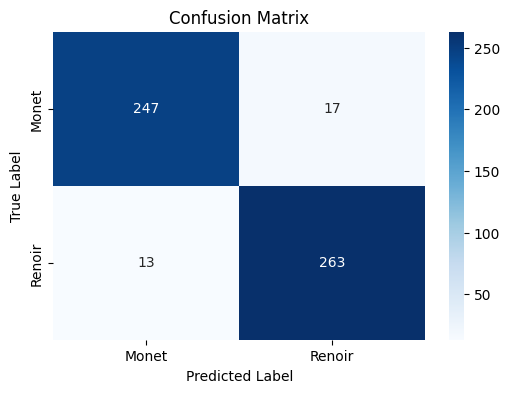

In [21]:
plot_confusion_matrix(model, X_test, y_test)

In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

def calculate_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)

    predicted_classes = (predictions > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, predicted_classes)
    balanced_accuracy = balanced_accuracy_score(y_test, predicted_classes)
    f1 = f1_score(y_test, predicted_classes)
    precision = precision_score(y_test, predicted_classes)
    recall = recall_score(y_test, predicted_classes)

    metrics_df = pd.DataFrame({
        'Métrica': ['Acurácia', 'Acurácia Balanceada', 'F1-Score', 'Precisão', 'Recall'],
        'Valor': [accuracy, balanced_accuracy, f1, precision, recall]
    })

    return metrics_df

metrics_table = calculate_metrics(model, X_test, y_test)

print(metrics_table)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
               Métrica     Valor
0             Acurácia  0.944444
1  Acurácia Balanceada  0.944252
2             F1-Score  0.946043
3             Precisão  0.939286
4               Recall  0.952899
